<!-- ---
title: "ml exercise 2"
author: "andrew richard"
format: 
    html:
        code-fold: false
output: html
jupyter: python3
execute:
    enabled: true
--- -->
## Machine Learning Exercise 2: Classification Basics

In this exercise, you'll be working with a dataset containing information about passengers on the Titanic. You can get more information about this dataset [here](https://www.kaggle.com/competitions/titanic). Our goal will be to build a model to predict whether a passenger survived the voyage.


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso 
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, confusion_matrix, classification_report, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.impute import SimpleImputer


Let's start by building a model using Age as a predictor variable.

When performing a train/test split, you usually want to make sure that the ratios of target values look the same in the training set and in the test set. This is especially true with imbalanced targets, where there are more observations in one class than the other. This can be done by, instead of a completely random split, by performing a **stratified** split.

1.  Create a DataFrame, X, which contains one column, Age, and a Series, y, which contains the target variable. Perform a 70/30 train/test split, stratifying by the target variable. Make sure that you set a random_state during this split. 


**initial setup**

In [74]:
titanic = pd.DataFrame(pd.read_csv("./data/titanic.csv"))
X = titanic[["Age"]]
y = titanic["Survived"]
print(X.shape, y.shape)


(891, 1) (891,)


In [75]:
print(titanic)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ... 



**train-test-split**


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)




2. Now, try and fit a logistic regression model using the [LogisticRegression class](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). When you do this, you're likely to encounter an error, that "Input X contains NaN." If you check, you'll find that there are some missing values in the Age column. In the next step, we'll address this issue.

**Logistic Regression attempt**

```python
logm = LogisticRegression()
log_fit = logm.fit(X_train, y_train)
```
```
ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
```
One option when a column contains missing values is to **impute** them, meaning to replace the missing values with an estimate. A simple way to impute is to fill missing values using the mean value. **Important Note:** When imputing with the mean, you should calculate the mean value only on the training data. In order to have an unbiased estimate of model performance, it is important that the model has access to no information about the test set.



3. Using a [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html), fit the training data and then use it to transform both the training and test data. 


In [77]:


imputer = SimpleImputer(missing_values = np.nan, strategy = "mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test) # don't want to refit to the test data, only transform



4. Now, fit your logistic regression model to the training data and generate predictions on the test data.


In [78]:

logm = LogisticRegression()
logm.fit(X_train, y_train)
y_pred = logm.predict(X_test)

There are multiple ways we can assess the performance of a classification model. A common way is put those predictions into a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), which compares the predicted and actual values. 

5. Create a confusion matrix out of the predictions. What do you find?


In [79]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
print(type(conf), conf)

<class 'pandas.core.frame.DataFrame'>      0  1
0  165  0
1  103  0


6. Plot the ROC curve. How well does your model do? Hint: You can use the [RocCurveDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html) to create this plot.


TPR = TP / (TP + FN)
FPR = FP / (TN + FP)

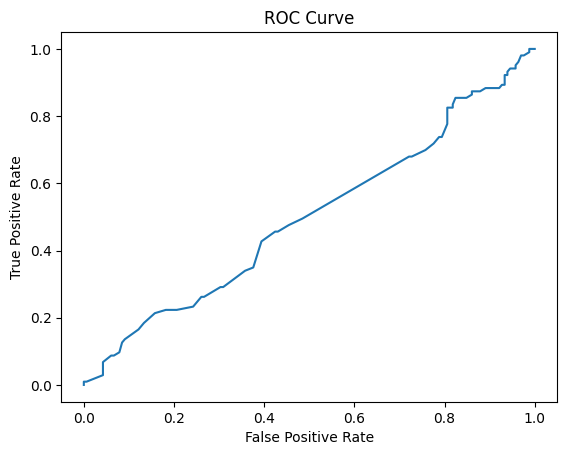

0.4984407178581936


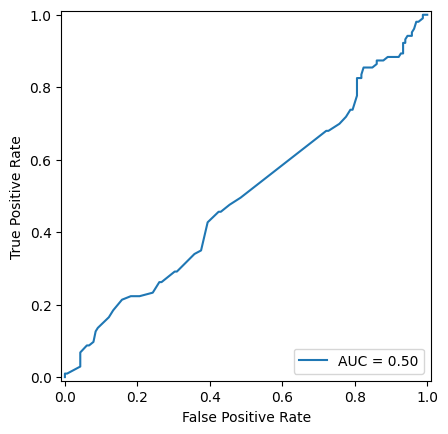

In [80]:
from sklearn import metrics
# the datacamp way
y_pred_probs = logm.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# with RocCurveDisplay
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()


You are likely to see that the model does not tend to predict that individuals survived the voyage. Let's see if we can determine why.

7. Look at the average age of survivors vs. those that did not survive the voyage. What do you find?


In [81]:
survivors = titanic[titanic["Survived"] == 1]
dead = titanic[titanic["Survived"] == 0]

avg_surv_age = survivors["Age"].mean()
avg_dead_age = dead["Age"].mean()

print(f'avg survivor age: {avg_surv_age}, avg dead age: {avg_dead_age}')

avg survivor age: 28.343689655172415, avg dead age: 30.62617924528302


8. Perhaps the actual age number is as important as whether a passenger was a child or an adult. Create a Boolean column that indicates whether a passenger was a child or an adult. Pick a cutoff age and if they were less than this age, label as a child. We'll see later on how we can make choosing the age part of our model building pipeline, but for now, choose an age or do some calculations to pick an age that you think might do well.

In [82]:
cutoff_age = 18

titanic["is_child"] = [1 if x  < cutoff_age else 0 for x in titanic["Age"]]
print(f'Number of children: {titanic["is_child"].sum()}')

Number of children: 113


9. When imputing the missing values, you'll need to change the strategy from mean to most_frequent. Impute the missing values, then fit the model using this new variable, generate predictions, and view the confusion matrix. How did your model do?

In [83]:
# specify target and predictor(s)
predictors = ['is_child']
target = 'Survived'

X = titanic[predictors]
y = titanic[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=y)

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# initializing our logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# print confusion matrix for model
print(confusion_matrix(y_test, y_pred))

[[143  22]
 [ 84  19]]


In [84]:
# declare new predictor variable
X = titanic[['is_child']]

# new train test split for new X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)

# Impute missing values
imputer = SimpleImputer(missing_values = np.nan, strategy = "most_frequent")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# make predictions
logm = LogisticRegression()
logm.fit(X_train, y_train)
y_pred = logm.predict(X_test)

# confusion matrix
conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
print(type(conf), conf)


<class 'pandas.core.frame.DataFrame'>      0   1
0  143  22
1   84  19



Other common metrics for classification include accuracy, precision, and recall. For more information, see https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall. These metrics can be viewed using the [classification_report function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html). 

10. Generate a classification report for your model.

In [85]:
target_names = ['Died', 'Survived']
classification_rep = metrics.classification_report(y_test, y_pred, target_names=target_names)
print(classification_rep)

              precision    recall  f1-score   support

        Died       0.63      0.87      0.73       165
    Survived       0.46      0.18      0.26       103

    accuracy                           0.60       268
   macro avg       0.55      0.53      0.50       268
weighted avg       0.57      0.60      0.55       268




Another important variable is the Sex variable. 

11. Create a DataFrame, X, which contains one column, Sex, and a Series, y, which contains the target variable. Perform a 70/30 train/test split, stratifying by the target variable. Make sure that you set a random_state during this split. 

In [86]:
predictors = ["Sex"]
target = "Survived"

X = titanic[predictors]
y = titanic[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size = 0.3,
    random_state = 42,
    stratify = y
)

If you inspect the Sex variable, you'll find that it is encoded as a string. We need to convert it to a numeric type so that our model can use it. We can do this using a [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).



12. Fit a OneHotEncoder to the training data and then transform both the training and test sets. Fit a model and evaluate the performance of this model.


In [91]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train_encoded, y_train)
y_pred = logreg.predict(X_test_encoded)

print(pd.DataFrame(confusion_matrix(y_pred, y_test)))

     0   1
0  138  33
1   27  70



Notice how we have used different types of transformations, an imputer for the age-related variables and a OneHotEncoder for the Sex variable. When we need to use multiple types of transformations, a [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) is useful. 

In the next part, we'll fit a model using both the Sex column and our column indicating whether the passenger was a child. 

13. Create a DataFrame, X, which contains two columns, Sex and the child indicator column, and a Series, y, which contains the target variable. Perform a 70/30 train/test split, stratifying by the target variable. Make sure that you set a random_state during this split. Then create a ColumnTransformer which will apply a SimpleImputer to the child column and a OneHotEncoder to the Sex column. Fit it on the training data and then transform the test data. Then fit a model on this and see how well it does.


In [ ]:
# identify variables of interest
predictors = ["Sex", "is_child"]
target = "Survived"

X = titanic[predictors]
y = titanic[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size = 0.3,
    random_state = 42,
    stratify = y
)

ct = ColumnTransformer(
    transformers=[
        ("imputer", SimpleImputer, X_train["Sex"]),
        ("ohe", OneHotEncoder, X_train["is_child"]),
    ]
)
ct.fit_transform(X_train)
ct.transform(X_test)

logm = LogisticRegression()
logm.fit(X_train, y_train)
y_pred = logm.predict(X_test




Finally, let's see how we can do all of this in a slightly more compact manner. We can use a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) which allows us to specify preprocessing steps (like the ColumnTransformer we used earlier) as well as the model we want to fit. 

14. Create a Pipeline which contains the ColumnTransformer and the LogisticRegression model. 

** If you've reached this point, let your instructors know so that they can check in with you. **

Stretch Goals

1. Try adding additional features and see how this affects your model. Think carefully about if you want passenger class to be treated as a numeric or a categorical variable.
